In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from seaborn import heatmap
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, RocCurveDisplay, auc, roc_curve, roc_auc_score

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [3]:
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

# Data preprocesing

## Load the data

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train_df = pd.read_csv('train_data.csv')
train_df.head()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,SubwayStation,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,51327,1985,2007,8,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,1.0,2.0,2.0,Daegu,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
1,48672,1985,2007,8,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,1.0,2.0,2.0,Daegu,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
2,380530,2006,2007,8,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,6.0,5.0,11.0,Sin-nam,1.0,1,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0
3,221238,1993,2007,8,1761,3,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
4,35840,1992,2007,8,355,5,corridor,individual_heating,management_in_trust,200.0,0.0,5min~10min,10min~15min,3.0,5.0,10.0,Myung-duk,7.0,1,1.0,1.0,5.0,1.0,4.0,3.0,5.0,5.0,3,16.0,17.0


In [6]:
test_df = pd.read_csv('test_data.csv')
test_df.head()

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,SubwayStation,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,2008,5,914,14,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
1,1993,2014,3,914,20,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
2,2013,2016,1,644,13,terraced,individual_heating,management_in_trust,8.0,930.0,0~5min,0-5min,7.0,6.0,14.0,Kyungbuk_uni_hospital,5.0,1,1.0,1.0,0.0,1.0,4.0,2.0,2.0,3.0,7,9.0,11.0
3,2009,2017,6,910,6,terraced,individual_heating,management_in_trust,25.0,203.0,0~5min,no_bus_stop_nearby,1.0,2.0,5.0,no_subway_nearby,2.0,1,0.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,5,6.0,5.0
4,1993,2013,12,1451,14,mixed,individual_heating,management_in_trust,523.0,536.0,0~5min,15min~20min,8.0,8.0,20.0,Myung-duk,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0


## Look at the data

In [7]:
train_df['SalePrice'] = (train_df['SalePrice'] > 300000).astype(int)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SalePrice                           4124 non-null   int64  
 1   YearBuilt                           4124 non-null   int64  
 2   YrSold                              4124 non-null   int64  
 3   MonthSold                           4124 non-null   int64  
 4   Size(sqf)                           4124 non-null   int64  
 5   Floor                               4124 non-null   int64  
 6   HallwayType                         4124 non-null   object 
 7   HeatingType                         4124 non-null   object 
 8   AptManageType                       4124 non-null   object 
 9   N_Parkinglot(Ground)                4124 non-null   float64
 10  N_Parkinglot(Basement)              4124 non-null   float64
 11  TimeToBusStop                       4124 no

In [9]:
train_df.describe()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_APT,N_manager,N_elevators,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
count,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000,4124.000000
mean,0.226722,2002.907129,2012.684772,6.201261,960.484239,11.994908,195.616392,572.357905,5.607177,6.333172,11.151552,4.141125,1.298982,0.912464,0.947381,1.932590,0.658341,3.018914,2.425800,2.663191,2.753637,5.801164,9.890883,10.861542
std,0.418762,8.825764,2.917335,3.398540,386.804458,7.548805,218.919683,409.246602,2.818877,3.193502,7.810642,1.775126,0.478587,0.814821,0.396927,2.199886,0.661033,0.940444,1.032846,1.547938,1.491970,2.340055,3.403815,4.417403
min,0.000000,1978.000000,2007.000000,1.000000,135.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1993.000000,2010.000000,3.000000,644.000000,6.000000,11.000000,184.000000,3.000000,5.000000,5.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,4.000000,8.000000,7.000000
50%,0.000000,2006.000000,2013.000000,6.000000,910.000000,11.000000,100.000000,536.000000,7.000000,6.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,2.000000,5.000000,9.000000,10.000000
75%,0.000000,2007.000000,2015.000000,9.000000,1160.000000,17.000000,249.000000,798.000000,8.000000,8.000000,16.000000,5.000000,2.000000,2.000000,1.000000,5.000000,1.000000,4.000000,3.000000,4.000000,4.000000,7.000000,13.000000,15.000000
max,1.000000,2015.000000,2017.000000,12.000000,2337.000000,43.000000,713.000000,1321.000000,13.000000,14.000000,27.000000,7.000000,2.000000,2.000000,2.000000,5.000000,2.000000,6.000000,4.000000,5.000000,5.000000,10.000000,16.000000,17.000000


array([[<AxesSubplot:title={'center':'SalePrice'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YrSold'}>,
        <AxesSubplot:title={'center':'MonthSold'}>,
        <AxesSubplot:title={'center':'Size(sqf)'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'N_Parkinglot(Ground)'}>,
        <AxesSubplot:title={'center':'N_Parkinglot(Basement)'}>,
        <AxesSubplot:title={'center':'N_APT'}>,
        <AxesSubplot:title={'center':'N_manager'}>],
       [<AxesSubplot:title={'center':'N_elevators'}>,
        <AxesSubplot:title={'center':'N_FacilitiesNearBy(PublicOffice)'}>,
        <AxesSubplot:title={'center':'N_FacilitiesNearBy(Hospital)'}>,
        <AxesSubplot:title={'center':'N_FacilitiesNearBy(Dpartmentstore)'}>,
        <AxesSubplot:title={'center':'N_FacilitiesNearBy(Mall)'}>],
       [<AxesSubplot:title={'center':'N_FacilitiesNearBy(ETC)'}>,
        <AxesSubplot:title={'center':'N_FacilitiesNear

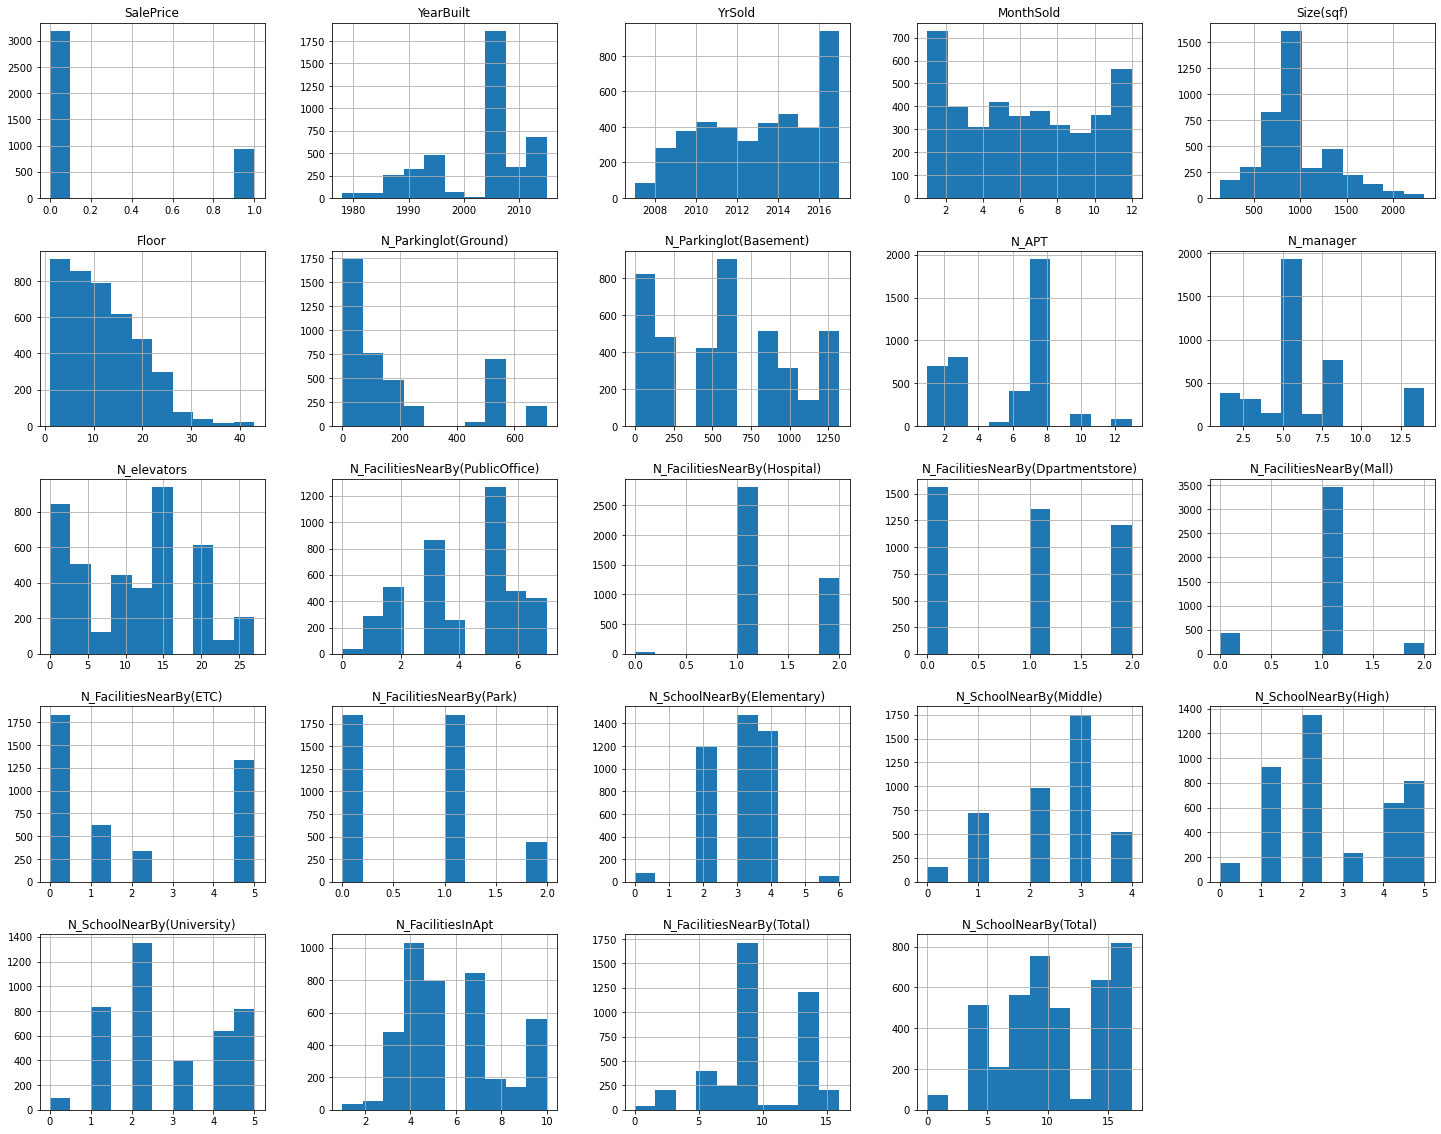

In [10]:
train_df.hist(figsize=(25,20))

### Distribution of the column that we are going to predict

<AxesSubplot:xlabel='SalePrice', ylabel='count'>

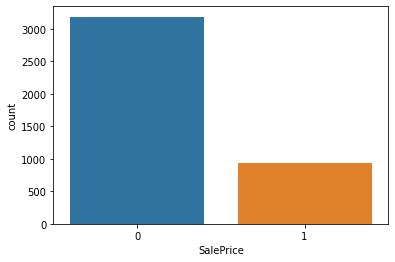

In [11]:
sns.countplot(x=train_df['SalePrice'])

In [12]:
train_df.loc[train_df['SalePrice'] == 1].shape[0] / train_df.shape[0]

0.226721629485936

Data is imbalanced => accuracy will not be a good metric to evaluate our model, because even classifier that returns only class 0 will have accuracy ~78%

## Correlation matrix

<AxesSubplot:>

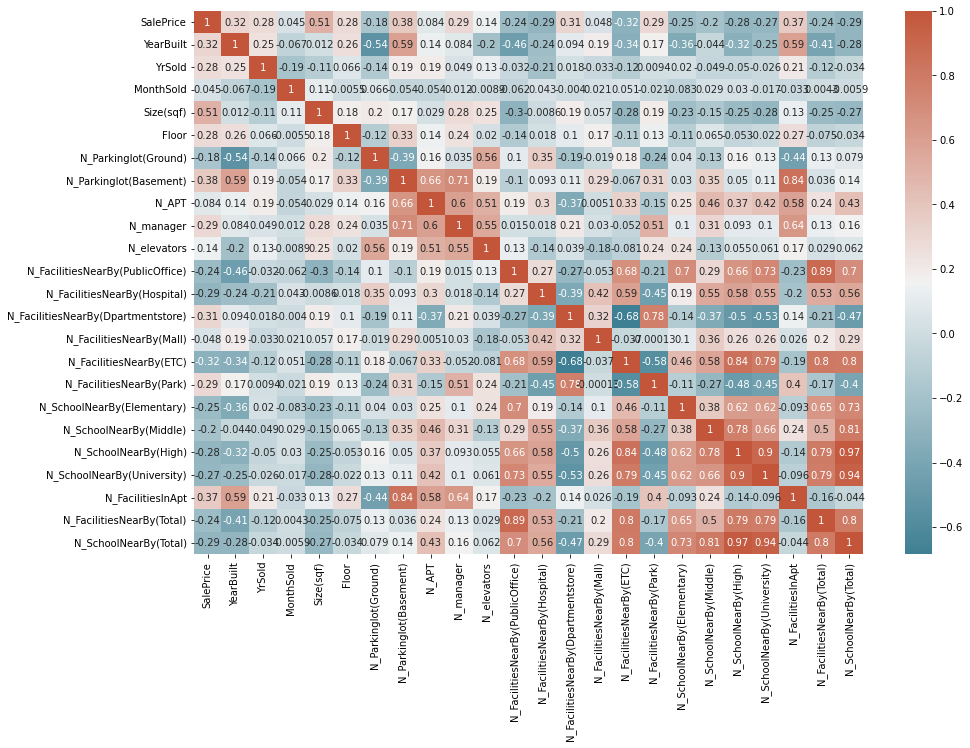

In [13]:
corr = train_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

## Categorical data

In [14]:
train_df['HallwayType'].value_counts()

terraced    2487
mixed       1189
corridor     448
Name: HallwayType, dtype: int64

In [15]:
train_df['HeatingType'].value_counts()

individual_heating    3914
central_heating        210
Name: HeatingType, dtype: int64

In [16]:
train_df['AptManageType'].value_counts()

management_in_trust    3869
self_management         255
Name: AptManageType, dtype: int64

In [17]:
train_df['TimeToBusStop'].value_counts()

0~5min         3163
5min~10min      927
10min~15min      34
Name: TimeToBusStop, dtype: int64

In [18]:
train_df['TimeToSubway'].value_counts()

0-5min                1943
5min~10min             807
15min~20min            672
10min~15min            547
no_bus_stop_nearby     155
Name: TimeToSubway, dtype: int64

In [19]:
train_df['SubwayStation'].value_counts()

Kyungbuk_uni_hospital    1139
Myung-duk                1064
Banwoldang                545
Bangoge                   517
Sin-nam                   445
no_subway_nearby          269
Chil-sung-market           77
Daegu                      68
Name: SubwayStation, dtype: int64

**Nominal attributes**:
- HallwayType
- HeatingType
- AptManageType
- SubwayStation
<br>Nominal attributes will be endoded with use of one-hot encoding<br>


**Ordinal attributes**:
- TimeToBusStop
- TimeToSubway

In both cases the less time the better<br>
Ordinal attributes will be encoded as integers


### Encoding of categorical attributes

#### Nominal attributes

In [20]:
cat_cols_1hot = ["HallwayType", 'HeatingType', 'AptManageType', 'SubwayStation']
train_cat_vals_1hot = pd.get_dummies(train_df[cat_cols_1hot])
test_cat_vals_1hot = pd.get_dummies(test_df[cat_cols_1hot])

In [21]:
train_cat_vals_1hot.head()

,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,HeatingType_central_heating,HeatingType_individual_heating,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0
2,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0
3,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0


In [22]:
test_cat_vals_1hot.head()

,HallwayType_corridor,HallwayType_mixed,HallwayType_terraced,HeatingType_central_heating,HeatingType_individual_heating,AptManageType_management_in_trust,AptManageType_self_management,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0
1,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0


In [23]:
train_df.drop(columns=cat_cols_1hot, inplace=True)
test_df.drop(columns=cat_cols_1hot, inplace=True)

#### Ordinal attributes

In [24]:
train_df['TimeToBusStop'] = pd.factorize(train_df['TimeToBusStop'])[0]
test_df['TimeToBusStop'] = pd.factorize(test_df['TimeToBusStop'])[0]

In [25]:
train_df['TimeToSubway'] = pd.factorize(train_df['TimeToSubway'])[0]
test_df['TimeToSubway'] = pd.factorize(test_df['TimeToSubway'])[0]

In [26]:
X_train = train_df.values[:, 1:]
X_test = test_df.values

In [27]:
X_train.shape

(4124, 25)

In [28]:
X_test.shape

(1767, 25)

In [29]:
y_train = train_df.values[:,0]

In [30]:
y_train

array([0., 0., 1., ..., 1., 1., 1.])

In [31]:
train_df.head()

,SalePrice,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,0,1985,2007,8,587,8,80.0,76.0,0,0,1.0,2.0,2.0,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
1,0,1985,2007,8,587,6,80.0,76.0,0,0,1.0,2.0,2.0,5.0,1,2.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,3,12.0,4.0
2,1,2006,2007,8,2056,8,249.0,536.0,0,1,6.0,5.0,11.0,1.0,1,0.0,1.0,0.0,0.0,2.0,2.0,1.0,2.0,5,3.0,7.0
3,0,1993,2007,8,1761,3,523.0,536.0,0,2,8.0,8.0,20.0,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
4,0,1992,2007,8,355,5,200.0,0.0,1,3,3.0,5.0,10.0,7.0,1,1.0,1.0,5.0,1.0,4.0,3.0,5.0,5.0,3,16.0,17.0


In [32]:
test_df.head()

,YearBuilt,YrSold,MonthSold,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_APT,N_manager,N_elevators,N_FacilitiesNearBy(PublicOffice),N_FacilitiesNearBy(Hospital),N_FacilitiesNearBy(Dpartmentstore),N_FacilitiesNearBy(Mall),N_FacilitiesNearBy(ETC),N_FacilitiesNearBy(Park),N_SchoolNearBy(Elementary),N_SchoolNearBy(Middle),N_SchoolNearBy(High),N_SchoolNearBy(University),N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,1993,2008,5,914,14,523.0,536.0,0,0,8.0,8.0,20.0,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
1,1993,2014,3,914,20,523.0,536.0,0,0,8.0,8.0,20.0,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0
2,2013,2016,1,644,13,8.0,930.0,0,1,7.0,6.0,14.0,5.0,1,1.0,1.0,0.0,1.0,4.0,2.0,2.0,3.0,7,9.0,11.0
3,2009,2017,6,910,6,25.0,203.0,0,2,1.0,2.0,5.0,2.0,1,0.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,5,6.0,5.0
4,1993,2013,12,1451,14,523.0,536.0,0,0,8.0,8.0,20.0,6.0,2,0.0,1.0,5.0,0.0,4.0,3.0,5.0,5.0,4,14.0,17.0


## Scaling of the data

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [34]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-2.02920677, -1.94885461,  0.52933238, ..., -1.19719577,
         0.61970852, -1.55348622],
       [-2.02920677, -1.94885461,  0.52933238, ..., -1.19719577,
         0.61970852, -1.55348622],
       [ 0.35047912, -1.94885461,  0.52933238, ..., -0.34241126,
        -2.02470415, -0.87427176],
       ...,
       [ 0.46379749,  1.47934723,  0.52933238, ...,  1.79455003,
        -0.26176237, -0.1950573 ],
       [-2.8224354 ,  1.47934723,  0.52933238, ..., -1.19719577,
        -0.84940963,  0.03134752],
       [ 0.46379749,  1.47934723,  0.52933238, ...,  1.79455003,
        -0.26176237, -0.1950573 ]])

In [35]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-1.12265977, -1.60603442, -0.35350668, ..., -0.76980351,
         1.20735578,  1.38977643],
       [-1.12265977,  0.45088668, -0.94206606, ..., -0.76980351,
         1.20735578,  1.38977643],
       [ 1.14370775,  1.13652705, -1.53062543, ...,  0.51237326,
        -0.26176237,  0.03134752],
       ...,
       [ 0.46379749, -0.92039405,  1.41217144, ...,  1.79455003,
        -0.26176237, -0.1950573 ],
       [ 0.35047912,  0.45088668,  1.70645112, ..., -0.34241126,
        -2.02470415, -0.87427176],
       [ 0.46379749,  0.45088668, -1.53062543, ..., -0.76980351,
        -0.26176237, -0.64786694]])

## Make the dataset

In [36]:
train_indices = np.random.rand(len(train_df))>0.3

In [37]:
numerical_data = torch.from_numpy(X_train_scaled[train_indices, :]).float()
categorical_data = torch.from_numpy(train_cat_vals_1hot[train_indices].values).float()
targets = torch.from_numpy(y_train[train_indices]).float()

test_numerical_data = torch.from_numpy(X_train_scaled[~train_indices, :]).float()
test_categorical_data = torch.from_numpy(train_cat_vals_1hot[~train_indices].values).float()
test_targets = torch.from_numpy(y_train[~train_indices]).float()

In [38]:
train_dataset = data.TensorDataset(numerical_data,categorical_data,targets)
test_dataset = data.TensorDataset(test_numerical_data,test_categorical_data,test_targets)

In [39]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model selection and training

In [40]:
def get_results(model, data_loader, threshold):
    y_true = []
    y_pred = []
    outputs = []
    
    model.eval()
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output > threshold
        
        y_pred.extend(pred.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())
        outputs.extend(output.detach().cpu().numpy())
        
    return outputs, y_true, y_pred

In [41]:
def get_accuracy(model, data_loader, threshold):
    correct = 0
    total = 0
    
    model.eval()
    for x, cat_x, labels in data_loader:
        x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
        output = model(x, cat_x)
        pred = output > threshold
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += x.shape[0]

    return (correct / total)

In [42]:
def training_loop(criterion, optimizer, model, lr, epochs, threshold, weight_decay, log_enabled=True):
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    iters = []
    losses = []
    train_acc_ls = []
    val_acc_ls = []
    
    for n in range(epochs):
        epoch_losses = []
        for x, cat_x, labels in iter(train_loader):
            x, cat_x, labels = x.to(device), cat_x.to(device), labels.to(device)
            model.train()
            out = model(x, cat_x).squeeze()
            
            loss = criterion(out, labels)
            loss.backward()  
            epoch_losses.append(loss.item())
            optimizer.step()              
            optimizer.zero_grad()         

        loss_mean = np.array(epoch_losses).mean()
        iters.append(n)
        losses.append(loss_mean)

        test_acc = get_accuracy(model, test_loader, threshold)
        train_acc = get_accuracy(model, train_loader, threshold)
        train_acc_ls.append(train_acc)
        val_acc_ls.append(test_acc)
        
        if log_enabled:
            print(f"Epoch: {n} loss: {loss_mean:.3} train_acc: {train_acc:.3} test_acc: {test_acc:.3}")
        

    if log_enabled:
        print("Final Training Accuracy: {}".format(train_acc_ls[-1]))
        print("Final Validation Accuracy: {}".format(val_acc_ls[-1]))
    
    return iters, losses, train_acc_ls, val_acc_ls

In [43]:
def plot_training(iters, losses, train_acc, val_acc):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    
    plt.show()

In [44]:
def plot_cms(y_true, y_pred, dataset_type):
    cm = confusion_matrix(y_true, y_pred)
    heatmap(cm, annot=True)
    plt.title(f'{dataset_type} confusion matrix')
    plt.xlabel('prediction')
    plt.ylabel('true label')
    plt.show()

In [45]:
def show_metrics(y_true, y_pred, dataset_type):
    plot_cms(y_true, y_pred, dataset_type)
    
    print(f"{dataset_type} set")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3}")
    print(f"Precision: {precision_score(y_true, y_pred):.3}")
    print(f"Recall: {recall_score(y_true, y_pred):.3}")
    print(f"F1 score: {f1_score(y_true, y_pred):.3}")

In [46]:
def plot_roc(y_true, outputs, data_loader, dataset_type):
    fpr, tpr, thresholds = roc_curve(y_true, outputs)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.title(dataset_type)
    plt.show()

## Neural net

In [47]:
class Sale_price_classifier(nn.Module):
    def __init__(self, num_layer1, num_layer2, drop_p, drop_emb):
        super(Sale_price_classifier, self).__init__()
        self.emb_layer1 = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.emb_act1 = nn.Tanh()
        self.emb_drop1 = nn.Dropout(drop_emb)
        
        self.emb_layer2 = nn.Linear(categorical_data.shape[1], categorical_data.shape[1])
        self.emb_act2 = nn.Tanh()
        self.emb_drop2 = nn.Dropout(drop_emb)
        
        self.layer1 = nn.Linear(categorical_data.shape[1] + numerical_data.shape[1], num_layer1)
        self.act1 = nn.LeakyReLU()
        self.drop1 = nn.Dropout(drop_p)
        self.bn1 = nn.BatchNorm1d(num_layer1)
        
        self.layer2 = nn.Linear(num_layer1, num_layer2)
        self.act2 = nn.LeakyReLU()
        self.drop2 = nn.Dropout(drop_p)
        self.bn2 = nn.BatchNorm1d(num_layer2)
        
        self.layer3 = nn.Linear(num_layer2, 1)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x, cat_x):
        cat_x_emb = self.emb_drop1(self.emb_act1(self.emb_layer1(cat_x)))
        cat_x_emb = self.emb_drop2(self.emb_act2(self.emb_layer2(cat_x_emb)))
        x = torch.cat([x, cat_x_emb], dim=1)
        x = self.bn1(self.drop1(self.act1(self.layer1(x))))
        x = self.bn2(self.drop2(self.act2(self.layer2(x))))
        output = self.act3(self.layer3(x))
        return output

### Hyperparameter tuning

Executing next cell might take a while

In [48]:
first_layer = [40, 50, 60]
second_layer = [40, 50, 60]
drop_p = [0.25, 0.4, 0.5, 0.6]
drop_emb = [0.25, 0.4, 0.5, 0.6]

results = pd.DataFrame()
for i in range(len(first_layer)):
    for j in range(len(second_layer)):
        for k in range(len(drop_p)):
            for l in range(len(drop_emb)):
                model = Sale_price_classifier(first_layer[i],second_layer[j],drop_p[k],drop_emb[l]).to(device)
                _, _, train_acc_ls, val_acc_ls = training_loop(nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets)), optim.Adam, model, lr=0.001, epochs=30, threshold=0.5, weight_decay=0, log_enabled=False)
                #print("first: {}, second: {}, drop_p: {}, drop_emb: {}, train_acc: {}, test_acc: {}".format(first_layer[i], second_layer[i], drop_p[k], drop_emb[l], train_acc_ls[-1], val_acc_ls[-1]))
                results = results.append({"first": first_layer[i], "second": second_layer[j], "drop_p": drop_p[k], "drop_emb": drop_emb[l], "train_acc":train_acc_ls[-1], "test_acc":val_acc_ls[-1]},ignore_index=True)

In [49]:
results

,first,second,drop_p,drop_emb,train_acc,test_acc
0,40.0,40.0,0.25,0.25,0.972329,0.965327
1,40.0,40.0,0.25,0.40,0.972680,0.966115
2,40.0,40.0,0.25,0.50,0.970578,0.966115
3,40.0,40.0,0.25,0.60,0.970578,0.963751
4,40.0,40.0,0.40,0.25,0.972329,0.959811
...,...,...,...,...,...,...
139,60.0,60.0,0.50,0.60,0.964623,0.957447
140,60.0,60.0,0.60,0.25,0.965674,0.959023
141,60.0,60.0,0.60,0.40,0.960420,0.955871
142,60.0,60.0,0.60,0.50,0.966025,0.961387


In [50]:
best_result = results.loc[results['test_acc']==results['test_acc'].max()].iloc[0]
best_result

first        50.000000
second       50.000000
drop_p        0.400000
drop_emb      0.250000
train_acc     0.972329
test_acc      0.968479
Name: 68, dtype: float64

In [51]:
LR = 0.001
EPOCHS = 30
THRESHOLD = 0.5
WEIGHT_DECAY = 0

In [52]:
model = Sale_price_classifier(int(best_result['first'].item()), int(best_result['second'].item()), best_result['drop_p'].item(), best_result['drop_emb'].item()).to(device)
model

Sale_price_classifier(
  (emb_layer1): Linear(in_features=15, out_features=15, bias=True)
  (emb_act1): Tanh()
  (emb_drop1): Dropout(p=0.25, inplace=False)
  (emb_layer2): Linear(in_features=15, out_features=15, bias=True)
  (emb_act2): Tanh()
  (emb_drop2): Dropout(p=0.25, inplace=False)
  (layer1): Linear(in_features=40, out_features=50, bias=True)
  (act1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (act2): LeakyReLU(negative_slope=0.01)
  (drop2): Dropout(p=0.4, inplace=False)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=50, out_features=1, bias=True)
  (act3): Sigmoid()
)

Epoch: 0 loss: 1.04 train_acc: 0.79 test_acc: 0.789
Epoch: 1 loss: 0.949 train_acc: 0.879 test_acc: 0.88
Epoch: 2 loss: 0.899 train_acc: 0.897 test_acc: 0.899
Epoch: 3 loss: 0.874 train_acc: 0.912 test_acc: 0.916
Epoch: 4 loss: 0.855 train_acc: 0.937 test_acc: 0.934
Epoch: 5 loss: 0.849 train_acc: 0.939 test_acc: 0.936
Epoch: 6 loss: 0.837 train_acc: 0.94 test_acc: 0.939
Epoch: 7 loss: 0.837 train_acc: 0.944 test_acc: 0.94
Epoch: 8 loss: 0.829 train_acc: 0.949 test_acc: 0.945
Epoch: 9 loss: 0.828 train_acc: 0.95 test_acc: 0.945
Epoch: 10 loss: 0.826 train_acc: 0.951 test_acc: 0.945
Epoch: 11 loss: 0.826 train_acc: 0.955 test_acc: 0.947
Epoch: 12 loss: 0.819 train_acc: 0.96 test_acc: 0.954
Epoch: 13 loss: 0.82 train_acc: 0.96 test_acc: 0.954
Epoch: 14 loss: 0.819 train_acc: 0.964 test_acc: 0.954
Epoch: 15 loss: 0.817 train_acc: 0.965 test_acc: 0.954
Epoch: 16 loss: 0.818 train_acc: 0.959 test_acc: 0.947
Epoch: 17 loss: 0.812 train_acc: 0.97 test_acc: 0.961
Epoch: 18 loss: 0.815 train_ac

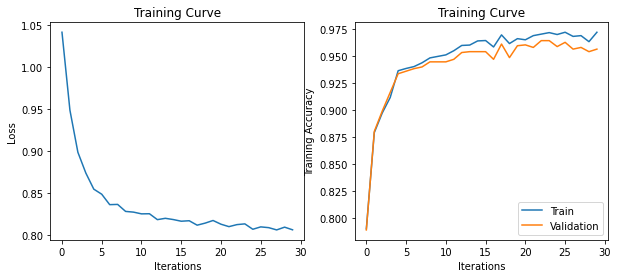

In [53]:
plot_training(*training_loop(nn.BCEWithLogitsLoss(pos_weight=(len(targets)-sum(targets))/sum(targets)), optim.Adam, model, LR, EPOCHS, THRESHOLD, WEIGHT_DECAY))

In [54]:
outputs_train, y_true_train, y_pred_train = get_results(model, train_loader, THRESHOLD)
outputs_test, y_true_test, y_pred_test = get_results(model, test_loader, THRESHOLD)

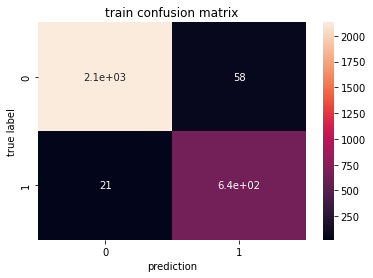

train set
Accuracy: 0.972
Precision: 0.917
Recall: 0.968
F1 score: 0.942


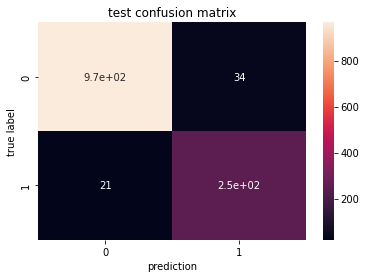

test set
Accuracy: 0.957
Precision: 0.879
Recall: 0.922
F1 score: 0.9


(None, None)

In [55]:
show_metrics(y_true_train, y_pred_train, "train"), show_metrics(y_true_test, y_pred_test, "test")

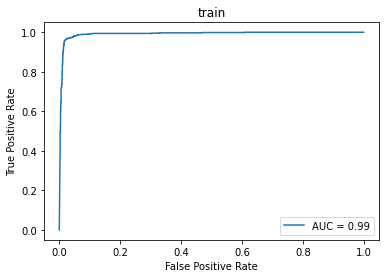

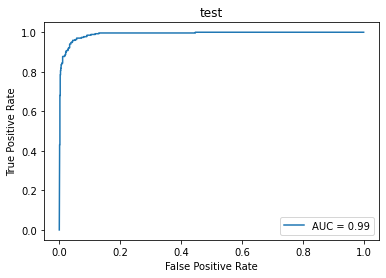

(None, None)

In [56]:
plot_roc(y_true_train, outputs_train, train_loader, "train"), plot_roc(y_true_test, outputs_test, test_loader, "test")

# Save the final predictions

In [57]:
num_x = torch.from_numpy(X_test_scaled).float().to(device)
cat_x = torch.from_numpy(test_cat_vals_1hot.values).float().to(device)

In [58]:
final_predictions = model(num_x, cat_x)

In [59]:
with open('test_predictions.csv', 'w') as fh:
    for i in final_predictions:
        fh.write(f'{i.item()}, {int(i.item()>THRESHOLD)}\n')